# License detector pipeline visualization

In [16]:
import importlib

import matplotlib

from notebooks.utils import cd_git_root, show, show_contours

matplotlib.rcParams["savefig.pad_inches"] = 0

cd_git_root()

In [17]:
from datasets.load import load_platesmania

datasets = load_platesmania()
ds = datasets.train

paths = ds.paths
to_filter = {
    # 1: "hard",
    # 11: "hard",
    # 12: "hard",
}
paths = [filename for i, filename in enumerate(paths) if i not in to_filter]
path = paths[0]

print("path:", path)

path: datasets/03-platesmania/pl_DW-3YT32_1.jpg


## Image loading

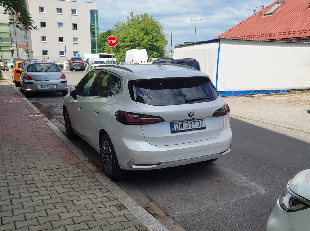

In [18]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering

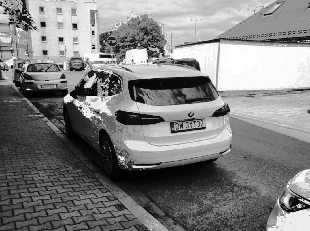

In [19]:
from twm_proj.implementation import initial_filter

importlib.reload(initial_filter)

filtered = initial_filter.InitialFilter().filter(image)
show(filtered)

## Edge filter

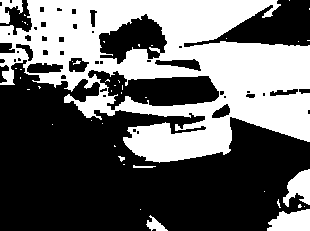

In [20]:
from twm_proj.implementation import edge_filter
importlib.reload(edge_filter)

edges = edge_filter.EdgeFilter().filter(filtered)
show(edges)

## Contour detector

contours count: 79
example contour:
 [[520 754]
 [518 756]
 [517 756]
 [517 759]
 [518 760]
 [518 761]
 [519 762]
 [525 762]
 [526 763]
 [526 767]
 [528 769]
 [528 776]
 [527 777]
 [518 777]
 [517 776]
 [517 775]
 [516 774]
 [516 772]
 [514 772]
 [513 771]
 [511 771]
 [510 772]
 [510 775]
 [509 776]
 [509 784]
 [508 785]
 [508 787]
 [509 788]
 [509 793]
 [511 795]
 [516 795]
 [517 796]
 [517 799]
 [518 800]
 [518 801]
 [522 801]
 [523 802]
 [523 809]
 [528 809]
 [528 805]
 [529 804]
 [529 803]
 [530 802]
 [542 802]
 [543 803]
 [543 809]
 [583 809]
 [583 808]
 [580 805]
 [579 805]
 [577 803]
 [573 803]
 [572 802]
 [572 797]
 [570 795]
 [569 795]
 [568 794]
 [568 793]
 [567 793]
 [566 792]
 [565 792]
 [564 791]
 [564 789]
 [563 788]
 [560 788]
 [559 787]
 [559 785]
 [555 781]
 [553 781]
 [552 780]
 [552 779]
 [551 778]
 [550 778]
 [544 772]
 [543 772]
 [541 770]
 [541 769]
 [537 769]
 [536 768]
 [536 766]
 [531 761]
 [530 761]
 [529 760]
 [527 760]
 [526 759]
 [526 758]
 [525 757]
 [523 

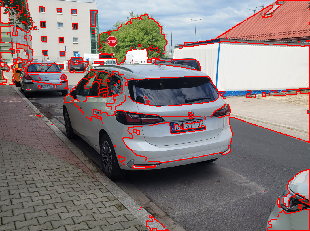

In [21]:
from twm_proj.implementation.contour_detector import ContourDetector

contours = [*ContourDetector().detect(edges)]
print("contours count:", len(contours))
print("example contour:\n", contours[0])
show_contours(image, contours)

## Rectangle detection

rects count: 1
example rect:
 [[106 226]
 [ 92 255]
 [210 255]
 [219 229]]


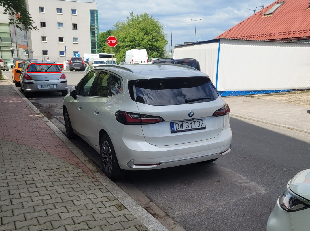

In [22]:
from twm_proj.implementation import rect_detector

importlib.reload(rect_detector)

rects = [rect_detector.RectDetector().detect(contour) for contour in contours]
rects = [rect for rect in rects if rect is not None]
print("rects count:", len(rects))
print("example rect:\n", rects[0] if rects else None)
show_contours(image, rects)

## Rectangle transforming

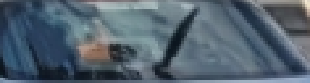

In [23]:
from twm_proj.implementation.rect_transformer import RectTransformer

rect_images = [RectTransformer().transform(image, rect) for rect in rects]
for rect_image in rect_images:
    show(rect_image)

## Rectangle classification

In [24]:
from twm_proj.implementation.rect_classifier import RectClassifier
from twm_proj.interface.rect_classifier import RectangleType

rect_classes = [RectClassifier().classify_with_differences(img) for img in rect_images]
display([(rect_class.name, differences) for rect_class, differences in rect_classes])

plates = [
    rect
    for rect, cls in zip(rect_images, rect_classes)
    if cls != RectangleType.NOT_PLATE
]

[('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.19158653846153845,
   <RectangleType.TWO_ROW_PLATE: 2>: 1.5872950819672131,
   <RectangleType.MINI_PLATE: 3>: 0.33452380952380956})]

## Pre-OCR processing

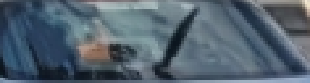

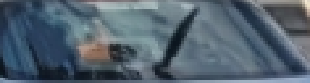

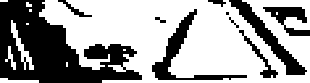

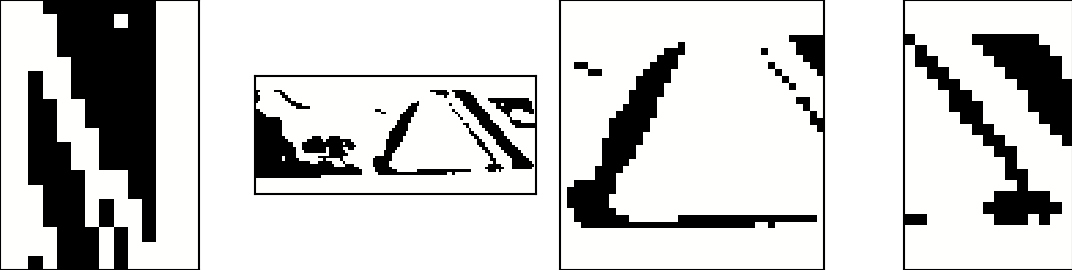

In [25]:
from notebooks.utils import show_collage
from twm_proj.implementation import pre_ocr

importlib.reload(pre_ocr)

plate_letters = []

for plate in plates:
    show(plate)
    plate = pre_ocr.PreOcr().cut(plate)
    show(plate)
    plate = pre_ocr.PreOcr().to_grayscale(plate)
    show(plate)

    letters = [*pre_ocr.PreOcr().get_letters(plate)]
    show_collage(letters, col_wrap=len(letters))

    plate_letters.append(letters)

## OCR

In [26]:
from twm_proj.implementation.ocr import Ocr


for letters in plate_letters:
    scanned_text = Ocr().scan_text(letters)
    print(scanned_text if scanned_text else None)

WAL5
